In [ ]:
#| default_exp basic

# Basic hydro functions (basic)

> The building blocks of ship performance analysis

This module contains low level functions related to naval architecture and hydrodynamics. Many of them are called by other functions within the library.

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import pandas as pd
from fastcore.test import *
import pkgutil
from io import BytesIO
from seawater import dens
from seawater.library import T90conv

## Load Water Dynamic Viscosity Table

In [ ]:
#| export
def load_water_properties() -> pd.DataFrame:
    """loads a 2D lookup table of water dynamic viscosity

    Returns:
        pd.DataFrame: dataframe of water properties
    """    
    water_properties = pkgutil.get_data('pyseatrials', 'water_properties/dyn_visc.csv')
    water_properties_df = pd.read_csv(BytesIO(water_properties), index_col=0)
    water_properties_df.columns = water_properties_df.columns.astype(int)
    
    return water_properties_df

## Calculate the Salinity of Water

In [ ]:
#| export
def calc_salinity(measured_density:float, #measured water density [kg/m3]
                  measured_temperature:float #measured water temperature [degC]
                  ) -> float:
    """calculate water salinity from density and temperature using UNESCO 1983 (EOS 80) polynomial

    Args:
        measured_density (float): measured water density
        measured_temperature (float): measured water temperature

    Returns:
        float: water salinity
    """    
    s = np.arange(0, 40, 0.02) #salinity
    t = T90conv(np.ones(len(s))*measured_temperature) #temperature
    p = np.zeros(len(s)) #pressure (sea level)

    salinity_calc = pd.DataFrame({'salinity':s, 'residual':np.abs((dens(s, t, p) - (np.ones(len(s)) * measured_density)))})
    salinity = salinity_calc.loc[salinity_calc['residual']==salinity_calc['residual'].min(), 'salinity']
    out = np.around(salinity.item(), 3)
    
    return out 

## Dynamic viscosity

Although a typical value of 1.18e-3 [kg/(ms)] is often used for dynamic viscosity, calculating the value at the current moment in time can still be advantageous. In such cases, the dynamic viscosity of seawater can be found using the equations of [Sharkawy et al 2010](https://doi.org/10.5004/dwt.2010.1079). This equation is used in the TEOS-10 standard and is implemented here.

$$\mu_{SW} = \mu_W (1 + AS +BS^2)$$

$$\mu_W = 4.2844e^{-5} + \frac{1}{0.157(T + 64.993)^2 - 91.296} $$

$$A = 1.541 + 1.998e^{-2} T - 9.52e^{-5}T^2 $$
$$B = 7.974 - 7.561e^{-2}T + 4.724e^{-4}T^2 $$

For the above equations, $T$ is temperature in degrees Celsius, and $S$ is the salinity in $\frac{g}{kg}$. The Sharkawy correlation is valid for the following conditions

- $0 \leq  S \leq 150$
- $0 \leq T \leq 180$

This method has an average accuracy of $\pm$ 4%. For alternative methods on calcualting the dynamic viscosity of seawater see [Qasem et al 2021](https://doi.org/10.1007/s13369-020-05020-5).


In [ ]:
#| export
def dynamic_viscosity(salinity:float, #A positive value of the water salinity [g/kg]
                      temperature:float #The temperature in celsius [C]
                     )->float: #returns values in [kg/ms]
    
    "Calculate the dynamic viscosity dependent on temperature and salinity"
    
    mu_w = 4.2844*10**(-5) + 1/(0.157*(temperature + 64.993)**2 - 91.296)
    
    A = 1.541 + 1.998 * temperature * 10**(-2) - 9.52 * temperature**2 * 10 ** (-5)
    B = 7.974 - 7.561 * temperature * 10**(-2) - 7.724 * temperature**2 * 10 ** (-4)
    
    return mu_w * (1 + A*salinity + B*salinity**2)

Applying the function to a range of temperatures shows that the viscosity is quite temperature dependent

In [ ]:
dynamic_viscosity(38e-3, np.linspace(10, 35, 5))

array([0.00140539, 0.00118849, 0.00102094, 0.0008885 , 0.0007818 ])

In [ ]:
#| hide

# I need a known example for this test

test_eq(dynamic_viscosity(0, 0), 0.0017914438244930712 )
test_eq(dynamic_viscosity(0, 1), 0.001730747475211275)
test_eq(dynamic_viscosity(1, 0), 0.0017914438244930712 *(1+ 1.541 +7.974))

Looking at a range of both temperature and salinity combinations, the viscosity appears to be more dependent on temperature than salinity in the range of possible values we find in the sea

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
np.linspace(25, 40, 16)

array([25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
       38., 39., 40.])

Text(0.5, 0, 'temperature')

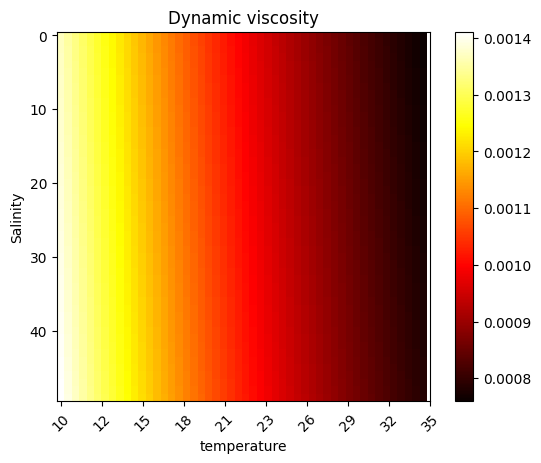

In [ ]:
counts = 50
comb_array = np.array(np.meshgrid(np.linspace(25, 40, counts )*10**(-3), np.linspace(10, 35, counts))).T.reshape(-1, 2)

comb_array

res = dynamic_viscosity(comb_array[:,0], comb_array[:,1]).reshape(counts,counts)

plt.imshow(res, cmap = 'hot')
plt.colorbar()
plt.title("Dynamic viscosity")
plt.ylabel('Salinity')
plt.xticks(np.linspace(0, 50, 10 ) ,np.linspace(25, 40, 10).astype(int), rotation=  45)
plt.xticks(np.linspace(0, 50, 10 ) ,np.linspace(10, 35, 10).astype(int), rotation=  45)
plt.xlabel('temperature')

### Kinematic viscosity

$$v = \frac{\mu_{SW}}{\rho},$$ 

where $\mu_{SW}$ is the dynamic viscosity of seawater, and $\rho$ is the density of the water

In [ ]:
#| export
def kinematic_viscosity_fn(dynamic_viscosity:float = 1.18e-3, #This value is typically 1.18e-3 [kg/(ms)]
                          water_density:float = 1026 #The density of water under current conditions [kg/m^3]
                         )-> float: #[m^2/s]
    
    "A simple wrapper calculating the ratio of dynamic viscosity and water density"
    
    return dynamic_viscosity/water_density
    

The kinematic viscosity can be calculated without entering any parameters, this uses the default values only

In [ ]:
kinematic_viscosity_fn()

1.1500974658869397e-06

However if the water conditions are not those of the default these alternative values can be entered as required

In [ ]:
dynamic_visc = 1.18e-3
water_density  = 1050
kinematic_viscosity_fn(dynamic_visc, water_density)


1.1238095238095239e-06

In [ ]:
#| hide
test_eq(kinematic_viscosity_fn(dynamic_visc, water_density)*water_density, 1.18e-3)


## Reynolds number
The reynolds number is a common formalua used throughout physiscs and engineering desciplines. Low reynolds numbers typically indicate laminar flow whilst high reynolds numbers typically indicate turbulent flow. However, in the case of ships the Reynolds number will always be large, however it is still a valuable component of many other calculations used by marine architects.


$$\text{Re} = \frac{V_s L_{os}}{v}, $$ 
where $V_s$ is the speed through wataer, $L_{os}$ is the length overall submerged of the ship, and $v$ is the kinematic viscosity.

In [ ]:
#| export
def reynolds_number_fn(stw:float, #Speed through water [m/s]
                      length:float, #Length of the vessel, $L_{os}$ Length overall submerged is typically used [m]
                      kinematic_viscosity:float # [m^2/s]
                      )->float: # Reynolds number is dimensionless
    
    "The Reynolds number is a element of fluid dynamics and is often used to predict whether flow is laminar or turbulent"
    
    return stw * length / kinematic_viscosity
    
    

As can be seen due to the small values of kinematic viscosity even a small ship going relatively slowly (approx 10kn) has a large reynolds number

In [ ]:
reynolds_number_fn(5, 50, 1.13e-6)

221238938.05309734

In [ ]:
#| hide
#Just checks nothing crazy has happened
test_eq(reynolds_number_fn(20, 50, 10),100)

## Froude Number

The ratio of flow inertia to an external field. The Froude number is often used in estimating the resistance of a partially submerged object in water

$$\text{Fr} = \frac{V_s}{\sqrt(g L_{WL})}, $$ 
where $V_S$ is the speed through water, $L_{WL}$ is the length at waterline, and $g$ is acceleration due to gravity.


In [ ]:
#| export

def froude_number_fn(stw:float, #speed through water [m/s]
                    length:float,#Length of vessel, typically $L_{wl}$ Length of waterline [m]
                    gravity:float = 9.81 #acceleration due to gravity [m/s^2]
                    )-> float : #The Froude number is a dimensionless value
    
    "The Froude number is useful for calculating the water resistance"
    
    return stw/np.sqrt(gravity * length)

As the Froude number is inversevly proportional to the size of the vessel, froude numbers tend to be small for ships which also tend to go at slower speeds.
Relative to the Reynolds number the Froude number is always much smaller.

In [ ]:
froude_number_fn(10, 50)

0.4515236409857309

In [ ]:
#| hide

#what tests could be useful here?

## Frictional resistance coefficent

The resistance coefficient related to the resistance of the water flowing over the hull

$$ C_F = \frac{c_1}{(log_{10}Re - 2)^2} + c_2,$$

Where $Re$ is the Reynolds number and $c_1$ and $c_2$ are constant adjustment values. ITTC-1957 (Hadler 1958) use the model-ship correlation line

$$ C_F = \frac{0.075}{(log_{10}Re - 2)^2} ,$$

Which is the default setting in pyseatrials

In [ ]:
#| export
def CF_fn(reynolds_number:float, #indicating the type of flow of the water
          c1:float = 0.075, # An adjustment value dault from ITTC-1957
          c2:float = 0 #An adjustment value the default is 0
      )-> float: #This is a dimensionaless value
    
    "An essential part of calculating the resistance experienced by the ship"
    
    return c1 / (np.log10(reynolds_number) -2) ** 2   + c2
    

In [ ]:
CF_fn(1e6)

0.0046875

In [ ]:
#| hide

#test_eq(CF_fn(1e6, 0), 0.0041875)

## Roughness resistance coefficient

The $19^{th}$ ITTC proposed a formula that corrects for the roughness of the vessel hull. 

$$\Delta C_F = \frac{11}{250} \left(  \left(\frac{k_s}{L_{WL}}\right)^{\frac{1}{3}} -10 \cdot \text{Re}^{-\frac{1}{3}} \right) + \frac{1}{8000} , $$ 

where $k_s$ is the surface roughness, $L_{WL}$ is the length of vessel at waterline, and $Re$ is the Reynolds number for current conditions.

This value is used in several other adjustments and calculations. Function for obtaining it is found here.

Other names for this variable are Roughness allowence

In [ ]:
#| export
def roughness_resistance_fn(
                          length:float, #Length of the vessel at waterline [m]
                          reynolds_number:float, # dimensionless value describing flow properties
                          surface_roughness:float = 150e-6, #The default value is outdated an modern hull covering are likely considerably less rough [m]
                          )-> float: # The dimensionless friction factor representing surface roughness of the hull
    
    """ 
    The function CF_fn calculates a dimensionless value representing the resistance experienced by a ship based on the given parameters.
    """

    ratio_value = surface_roughness / length
    return (11/250)* (ratio_value**(1/3) - 10 * reynolds_number**(-1/3)) + (1/8e3)
    

In [ ]:
roughness_resistance_fn(189, 2.63e9)

0.00021361371568178405

In [ ]:
#| hide

#I have no idea what is a reasonable value here so would require some input

# Form factor

The form factor (1+k) is a dimensionless value used to modify the friction coefficient to the hull form of the vessel. The below expression uses the Gross & Watanabe method (Form factor, appendix 4, report of performance committee 13th ITTC. Hamburg (1972) (\[no doi or digital reference available\])

$$1 + k = 1.017 + 20 C_B \left( \frac{B}{L_{pp}} \right)^2 \sqrt{\frac{T_M}{B}}$$

where $C_B$ is block coefficient, $B$ is the beam of the ship, $L_{pp}$ is the length between perpendiculars and $T_M$ is the draught at midship

In [ ]:
#| export

def calculate_form_factor(C_B: float, # The block coefficient
                          B: float, #Beam of the vessel [m]
                          L_pp: float, #The length between perpendiculars [m]
                          T_M: float #The draught at midship [m]
                          ) -> float: #The dimensionless form factor for the ship
    """
    The function `calculate_form_factor` calculates the dimensionless form factor (1+k) for a ship using the Gross & Watanabe method.
    """
    k = 1.017 + 20 * C_B * (B / L_pp)**2 * (T_M / B)**0.5
    return k


In [ ]:
form_factor = calculate_form_factor(0.7, 10.5, 100, 5.2)

In [ ]:
#| hide
# Test case 1: Simple case with an example set of parameters
test_case1 = {
    'C_B': 0.85,
    'B': 20,
    'L_pp': 100,
    'T_M': 5
}

k1 = calculate_form_factor(**test_case1)
test_close(k1, 1.357, eps=1e-4)

# Test case 2: Another example with different parameters
test_case2 = {
    'C_B': 0.9,
    'B': 30,
    'L_pp': 150,
    'T_M': 10
}

k2 = calculate_form_factor(**test_case2)
test_close(k2, 1.4326, eps=1e-4)

# Test case 3: Test with same beam and length between perpendiculars
test_case3 = {
    'C_B': 0.8,
    'B': 25,
    'L_pp': 25,
    'T_M': 7
}

k3 = calculate_form_factor(**test_case3)
test_close(k3, 9.483, eps=1e-3)

# Viscous resistance coefficient

The viscous resistance coefficient is a dimensionless value that is used to describe the kind of frictional forces a vessel will encounter when moving through water.

$$C_v' = 1.06 C_F  (1+k) + \Delta C_F$$

where $C_F$ is the frictional corellation coefficient, $(1+k)$ is the form factor, and $\Delta C_F$ is the roughness resistance coefficient

In [ ]:
#| export

def calculate_viscous_resistance_coef(C_F: float, #The frictional correlation coefficient
                                 form_factor: float, #The form factor (1+k)
                                 delta_C_F: float #The roughness resistance coefficient
                                 ) -> float: #The coefficient of viscous friction
    """
    The function `calculate_viscous_resistance_coef` calculates the dimensionless viscous resistance coefficient for a vessel based on the given parameters.
    """
    return 1.06 * C_F * form_factor + delta_C_F * C_F

As an example 

In [ ]:
viscous_resistance_coef = calculate_viscous_resistance_coef(0.005, 1.189, 0.002)
print(viscous_resistance_coef)

0.0063117


Using the above example we can find the total frictional resistance due to the viscosity using $R_V = C_v'\frac{1}{2} \rho  V_S^2 S$

In [ ]:
density = 1026 # rho [kg/(m^-3)]
speed_through_water = 9 # V_s [ms^-1]
wetted_surface_area = 3000 #S [m^2]

total_viscous_resistance = viscous_resistance_coef/2 * density * speed_through_water * wetted_surface_area

print(total_viscous_resistance)

87423.35669999999


In [ ]:
#| hide
# Test with example values from the prompt
test_eq(np.round(calculate_viscous_resistance_coef(0.005, 1.189, 0.002),4), 0.0063)
# Test with zero values
test_eq(calculate_viscous_resistance_coef(0, 0, 0), 0)
# Test with negative values
test_eq(round(calculate_viscous_resistance_coef(-0.005, -1.189, -0.002), 4), 0.0063)

# Total resistance coefficient

The total resistance coeficient is the value describing the sum of all resistances experienced by the ship as it moves through the water. The coefficient can be found using the following equation

$C_t'\ = \frac{2 R_T}{\rho  V_S^2 S},$

Where $R_T$ is the total resistance experienced by the ship, $\rho$ is the density of the water, $V$ is the speed through water, and $S$ is the wetted surface area of the ship. As can be seen the equation is very similar to the to the equation of viscous friction.  

In [ ]:
#| export
def calculate_total_resistance_coef(total_resistance:float, #The total resistive force experienced by the ship [N]
                                    stw:float, #The speed through water of the ship [m/s]
                                    wsa:float, #The wetted surface area of the ship [m^2]
                                    water_density:float = 1026 #The desnity of seawater [kg/m^3]
                                    )->float: #The dimensionless coefficient of total resistance of the ship
    
    """ 
    The function `calculate_total_resistance_coef` calculates the dimensionless coefficient of total resistance for a ship based on the given parameters.
    """

    denominator = 0.5 * water_density * wsa * stw**2

    return total_resistance/denominator 

In [ ]:
total_resistance = 10e6
stw = 12
wsa = 3e4
water_density = 1020

calculate_total_resistance_coef(total_resistance, stw, wsa, water_density)

0.004538852578068265

In [ ]:
test_eq(calculate_total_resistance_coef(0, stw, wsa, water_density),0)
test_eq(calculate_total_resistance_coef(0.5 * water_density * wsa * stw**2, stw, wsa, water_density),1)
test_eq(calculate_total_resistance_coef(1, 4, 1, 1),2*(1/4)**2)


# Wetted surface area

The wetted surface area of a ship is useful for calculating the total surface friction. There are many ways of calculating the wetted surface area, however one of the most popular is the Holtrop-Mennen formula developed from analysing several hundred model tests [Holtrop-Mennen](https://doi.org/10.3233/ISP-1982-2933501). The expression is shown below

$$ \textrm{WSA} = L(2T+B)\sqrt{C_M}(0.453 + 0.4425C_B - 0.2862C_M - 0.003467\frac{B}{T} + 0.3696 C_{WP}) + 2.38 \frac{A_{BT}}{C_B} $$

where $T$ is the draft, B is the beam, $C_M$ is the midship section coefficient, $C_B$ is the block coefficient, $C_{WP}$ is the waterplance area coefficient, and $A_{BT}$ is the transverse sectional area of the bulb. This equation produces good results for a wide range of ships; however, there may be deviations in ships with unusual hull forms, such as multi-hulled vessels or those with asymmetrical designs.


In [ ]:
#| export
def wetted_surface_area(draft: float, #The draft of the ship [m]
                        beam: float, # The beam of the ship [m]
                        length: float, # The length of the ship [m]
                        midship_section_coeff: float, # The midship section coefficient [none]
                        block_coeff: float, #The block coefficient [none]
                        waterplane_area_coeff: float, # The waterplane area coefficient [none]
                        transverse_sectional_area: float #The transverse sectional area of the bulb [m^2]
                        )->float:  # The wetted surface area of the ship [m^2]
    """
    The function `wetted_surface_area` calculates the wetted surface area of a ship using the Hotropp-Mennen formula.

    """

    wetted_surface_area = length * (2 * draft + beam) * np.sqrt(midship_section_coeff) * (0.453 + 0.4425 * block_coeff - 0.2862 * midship_section_coeff - 0.003467 * (beam / draft) + 0.3696 * waterplane_area_coeff) + 2.38 * (transverse_sectional_area / block_coeff)

    return wetted_surface_area

In [ ]:
draft = 10.5 # meters
beam = 16.2 # meters
length = 200 # meters
midship_section_coeff = 0.8
block_coeff = 0.7
waterplane_area_coeff = 0.9
transverse_sectional_area = 50 # square meters

wetted_area = wetted_surface_area(draft, beam, length, midship_section_coeff, block_coeff, waterplane_area_coeff, transverse_sectional_area)

print(f"The wetted surface area of the ship is: {round(wetted_area)} square meters")


The wetted surface area of the ship is: 5900 square meters


## Air Density

Calcuate the air density based on the the function "FUNCTION ESW(T)" in https://icoads.noaa.gov/software/other/profs

In [ ]:
#| export
def air_density(P:float, #air pressure in mbar
                T:float, #air temperature in degC
                RH:float #air relative humidity as %
                ):
    """Calculate air density based on https://icoads.noaa.gov/software/other/profs

    Args:
        P (float): Air pressure in mbar
        T (float): Air temperature in degC
        RH (float): Air relative humidity
    """
    Ppa = P * 100 #convert from mbar to PA
    Tk = T + 273.15 #air temp in Kelvin
    
    Rd = 287.058 #gas constant for dry air J/(kg.K)
    Rv = 461.495  #gas constant for water vapour J/(kg.K)
    
    Eso = 6.1078
    c0 = 0.99999683
    c1 = -0.90826951*10**-2
    c2 = 0.78736169*10**-4
    c3 = -0.61117958*10**-6
    c4 = 0.43884187*10**-8
    c5 = -0.29883885*10**-10
    c6 = 0.21874425*10**-12
    c7 = -0.17892321*10**-14
    c8 = 0.11112018*10**-16
    c9 = -0.30994571*10**-19
    p = c0+T*(c1+T*(c2+T*(c3+T*(c4+T*(c5+T*(c6+T*(c7+T*(c8+T*(c9)))))))))
    Es = Eso/(p**8)

    pv = Es * RH
    pd = Ppa - pv
    rho = (pd / (Rd * Tk)) + (pv / (Rv * Tk))
    
    return rho

In [ ]:
air_density(P=1015, #air pressure in mbar
            T=20, #air temperature in degC
            RH=50 #air relative humidity as %
            )

1.2009152519273378

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()